In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the label map
with open('/content/drive/MyDrive/land-use-classification/data/label_map.json', 'r') as f:
    label_map = json.load(f)

In [3]:
# Define the paths to the image directories and CSV files
train_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/train'
val_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/validation'
test_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/test'

train_csv = '/content/drive/MyDrive/land-use-classification/data/train.csv'
val_csv = '/content/drive/MyDrive/land-use-classification/data/validation.csv'
test_csv = '/content/drive/MyDrive/land-use-classification/data/test.csv'

In [4]:
# Load the CSV files into Pandas dataframes
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

In [5]:
# Define the image size and batch size
IMG_SIZE = 256
BATCH_SIZE = 32

In [6]:
# Augment training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Define image data generators using ImageDataGenerator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=train_dir,
                                                    x_col='Filename',
                                                    y_col='ClassName',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(val_df,
                                                directory=val_dir,
                                                x_col='Filename',
                                                y_col='ClassName',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=test_dir,
                                                  x_col='Filename',
                                                  y_col='ClassName',
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7350 validated image filenames belonging to 21 classes.
Found 2100 validated image filenames belonging to 21 classes.
Found 1050 validated image filenames belonging to 21 classes.


In [7]:
# Define a baseline CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_map), activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)//BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_df)//BATCH_SIZE)

Epoch 1/20
229/229 [==============================] - 7734s 34s/step - loss: 2.7701 - accuracy: 0.1119 - val_loss: 2.3722 - val_accuracy: 0.2106
Epoch 2/20
229/229 [==============================] - 129s 563ms/step - loss: 2.2542 - accuracy: 0.2624 - val_loss: 1.8634 - val_accuracy: 0.3798
Epoch 3/20
229/229 [==============================] - 130s 566ms/step - loss: 1.8785 - accuracy: 0.3755 - val_loss: 1.5759 - val_accuracy: 0.4827
Epoch 4/20
229/229 [==============================] - 129s 565ms/step - loss: 1.5899 - accuracy: 0.4724 - val_loss: 1.3859 - val_accuracy: 0.5389
Epoch 5/20
229/229 [==============================] - 129s 565ms/step - loss: 1.4053 - accuracy: 0.5230 - val_loss: 1.2909 - val_accuracy: 0.5808
Epoch 6/20
229/229 [==============================] - 129s 562ms/step - loss: 1.2786 - accuracy: 0.5676 - val_loss: 1.0533 - val_accuracy: 0.6452
Epoch 7/20
229/229 [==============================] - 129s 564ms/step - loss: 1.1638 - accuracy: 0.6078 - val_loss: 0.9878 - 

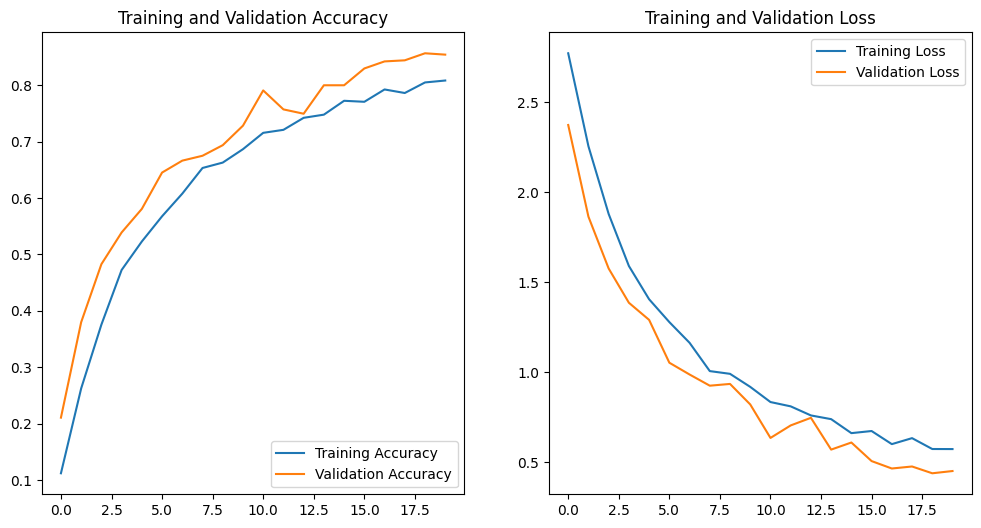

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df)//BATCH_SIZE)
print('Test accuracy:', test_acc)

32/32 [==============================] - 799s 26s/step - loss: 0.4523 - accuracy: 0.8574
Test accuracy: 0.857421875


In [12]:
# See If we can improve the CNN model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(21, activation='softmax')
])

In [13]:
# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Try to speed things up
BATCH_SIZE=50

# Fit the model
history_2 = model_2.fit(train_generator,
                    steps_per_epoch=len(train_df)//BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_df)//BATCH_SIZE)

Epoch 1/20
147/147 [==============================] - 89s 570ms/step - loss: 3.0510 - accuracy: 0.0457 - val_loss: 3.0401 - val_accuracy: 0.0640
Epoch 2/20
147/147 [==============================] - 84s 570ms/step - loss: 2.8324 - accuracy: 0.0939 - val_loss: 3.2300 - val_accuracy: 0.0759
Epoch 3/20
147/147 [==============================] - 83s 564ms/step - loss: 2.5579 - accuracy: 0.1351 - val_loss: 3.2094 - val_accuracy: 0.0818
Epoch 4/20
147/147 [==============================] - 84s 570ms/step - loss: 2.2938 - accuracy: 0.2243 - val_loss: 2.4578 - val_accuracy: 0.1979
Epoch 5/20
147/147 [==============================] - 84s 569ms/step - loss: 2.0461 - accuracy: 0.3102 - val_loss: 2.2654 - val_accuracy: 0.2515
Epoch 6/20
147/147 [==============================] - 83s 565ms/step - loss: 1.8601 - accuracy: 0.3699 - val_loss: 2.0354 - val_accuracy: 0.3103
Epoch 7/20
147/147 [==============================] - 83s 567ms/step - loss: 1.7324 - accuracy: 0.4058 - val_loss: 2.3717 - val_ac